# TidyTuesday 2019-01-29

In [275]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (8, 5),
    'figure.subplot.hspace': 0.5,
    'figure.titlesize': 'large',
    'axes.titlesize': 'medium',
    'axes.labelsize': 'small',
    'xtick.labelsize': 'xx-small',
    'ytick.labelsize': 'xx-small',
})

## Dataset

In [276]:
data = pd.read_csv(os.path.join('..', 'data', 'processed', 'milkcow_facts.csv'))

data.head()

,year,avg_milk_cow_number,milk_per_cow,milk_production_lbs,avg_price_milk,dairy_ration,milk_feed_price_ratio,milk_cow_cost_per_animal,milk_volume_to_buy_cow_in_lbs,alfalfa_hay_price,slaughter_cow_price
0,1980.0,10799000.0,11891,1.284060e+11,0.130,0.048374,2.717149,1190,9153.846154,72.000000,0.4573
1,1981.0,10898000.0,12183,1.327700e+11,0.138,0.050352,2.759031,1200,8695.652174,70.900000,0.4193
2,1982.0,11011000.0,12306,1.355050e+11,0.136,0.044221,3.088127,1110,8161.764706,72.733333,0.3996
3,1983.0,11059000.0,12622,1.395880e+11,0.136,0.052350,2.609620,1030,7573.529412,78.700000,0.3935
4,1984.0,10793000.0,12541,1.353510e+11,0.135,0.053388,2.540000,895,6629.629630,79.483333,0.3981


In [277]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           35 non-null     float64
 1   avg_milk_cow_number            35 non-null     float64
 2   milk_per_cow                   35 non-null     int64  
 3   milk_production_lbs            35 non-null     float64
 4   avg_price_milk                 35 non-null     float64
 5   dairy_ration                   35 non-null     float64
 6   milk_feed_price_ratio          35 non-null     float64
 7   milk_cow_cost_per_animal       35 non-null     int64  
 8   milk_volume_to_buy_cow_in_lbs  35 non-null     float64
 9   alfalfa_hay_price              35 non-null     float64
 10  slaughter_cow_price            35 non-null     float64
dtypes: float64(9), int64(2)
memory usage: 3.1 KB


### Data cleansing

In [278]:
data['year'] = data['year'].map(int)

data.head()

,year,avg_milk_cow_number,milk_per_cow,milk_production_lbs,avg_price_milk,dairy_ration,milk_feed_price_ratio,milk_cow_cost_per_animal,milk_volume_to_buy_cow_in_lbs,alfalfa_hay_price,slaughter_cow_price
0,1980,10799000.0,11891,1.284060e+11,0.130,0.048374,2.717149,1190,9153.846154,72.000000,0.4573
1,1981,10898000.0,12183,1.327700e+11,0.138,0.050352,2.759031,1200,8695.652174,70.900000,0.4193
2,1982,11011000.0,12306,1.355050e+11,0.136,0.044221,3.088127,1110,8161.764706,72.733333,0.3996
3,1983,11059000.0,12622,1.395880e+11,0.136,0.052350,2.609620,1030,7573.529412,78.700000,0.3935
4,1984,10793000.0,12541,1.353510e+11,0.135,0.053388,2.540000,895,6629.629630,79.483333,0.3981


## Exploratory Data Analysis

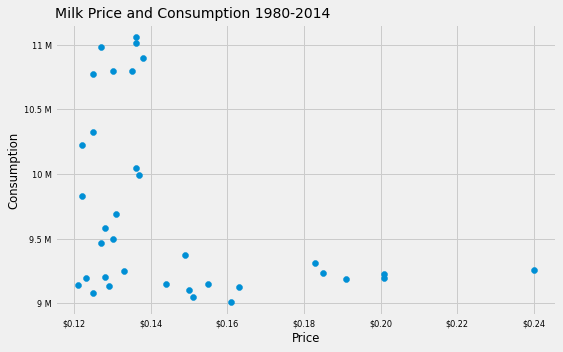

In [279]:
years = data['year'].tolist()
year_min = min(years)
year_max = max(years)


fig, ax = plt.subplots(1, 1)

ax.scatter(data['avg_price_milk'], data['avg_milk_cow_number'])
ax.set_xlabel('Price')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))
ax.set_ylabel('Consumption')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(f'Milk Price and Consumption {year_min}-{year_max}', loc='left')


plt.show()

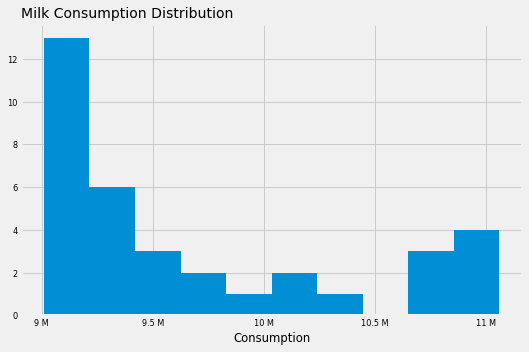

In [280]:
fig, ax = plt.subplots(1, 1)

ax.hist(data['avg_milk_cow_number'])
ax.set_xlabel('Consumption')
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title('Milk Consumption Distribution', loc='left')


plt.show()

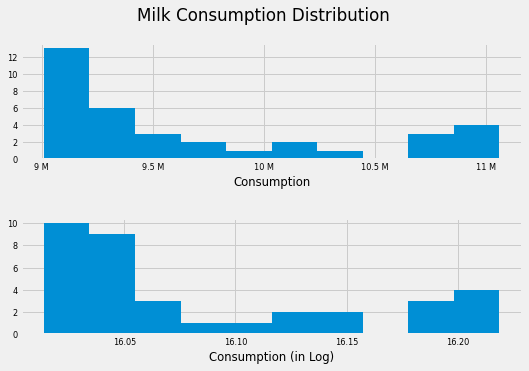

In [281]:
data_viz = data.copy()
data_viz['avg_milk_cow_number_ln'] = data_viz['avg_milk_cow_number'].map(lambda x: np.log(x))


fig, axs = plt.subplots(2, 1)

axs[0].hist(data['avg_milk_cow_number'])
axs[0].set_xlabel('Consumption')
axs[0].xaxis.set_major_formatter(ticker.EngFormatter())

axs[1].hist(data_viz['avg_milk_cow_number_ln'])
axs[1].set_xlabel('Consumption (in Log)')

fig.suptitle('Milk Consumption Distribution')


plt.show()

### Model

### Data Preprocess

In [282]:
data_train = data.copy()

data_train['avg_milk_cow_number_ln'] = data_train['avg_milk_cow_number'].map(lambda x: np.log(x))
data_train = data_train[['avg_milk_cow_number_ln', 'avg_price_milk']]

data_train.head()

,avg_milk_cow_number_ln,avg_price_milk
0,16.194964,0.130
1,16.204090,0.138
2,16.214405,0.136
3,16.218755,0.136
4,16.194408,0.135


In [283]:
x_columns = ['avg_price_milk']
y_column = ['avg_milk_cow_number_ln']

x_train = data_train[x_columns]
y_train = data_train[y_column]

### Model Fitting

In [284]:
model = LinearRegression()


model.fit(x_train, y_train)

LinearRegression()

### Model Evaluation

In [285]:
y_train_pred = model.predict(x_train)


error = mean_squared_error(y_train, y_train_pred, squared=False)
error

0.06350708525730886

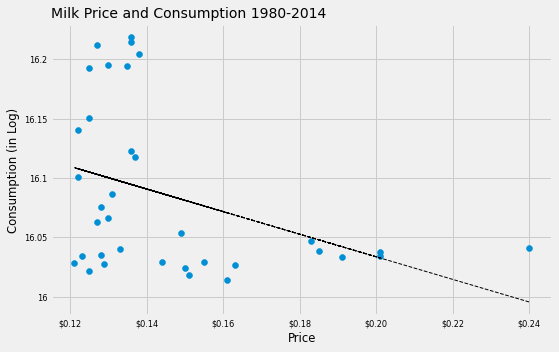

In [286]:
data_train['prediction'] = y_train_pred


fig, ax = plt.subplots(1, 1)

ax.scatter(data_train['avg_price_milk'], data_train['avg_milk_cow_number_ln'])
ax.plot(data_train['avg_price_milk'], data_train['prediction'], color='black', linewidth=1, linestyle='dashed')
ax.set_xlabel('Price')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))
ax.set_ylabel('Consumption (in Log)')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(f'Milk Price and Consumption {year_min}-{year_max}', loc='left')


plt.show()